In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import logging
logger = logging.getLogger('detectron2')

import numpy as np
import cv2
from PIL import Image
from IPython.display import display

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [2]:
#Paths
from pathlib import Path
base_folder = Path('..')
data_folder = base_folder/'data'/'til2020'
train_imgs_folder = data_folder/'train'
train_annotations = data_folder/'train.json'
val_imgs_folder = data_folder/'val'
val_annotations = data_folder/'val.json'
test_imgs_folder = data_folder/'CV_interim_images'
test_annotations = data_folder/'CV_interim_evaluation.json'

save_model_folder = base_folder/'ckpts'
load_model_folder = base_folder/'final_ckpts'

In [3]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("til_val", {}, val_annotations, val_imgs_folder)

In [4]:
cfg_cropper = get_cfg()
cfg_cropper.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
cfg_cropper.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")

cropper = DefaultPredictor(cfg_cropper)

In [5]:
from detectron2.data import build_detection_train_loader
#https://detectron2.readthedocs.io/modules/config.html
#btw, i added some custom config options for my checkpointer and pipeline
from detectron2 import model_zoo

cfg_boxer = get_cfg()
cfg_boxer.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))

cfg_boxer.DATASETS.TRAIN = ("til_val",)
cfg_boxer.DATASETS.TEST = ("til_val",)

cfg_boxer.MODEL.ROI_HEADS.NUM_CLASSES = 5 #number of categories
cfg_boxer.MODEL.WEIGHTS = str(load_model_folder/"ft-til_resnet101_rcnn-17999-best_val.pth")

boxer = DefaultPredictor(cfg_boxer)
build_detection_train_loader(cfg_boxer)#force metadata to load

[06/16 20:39:48 d2.data.datasets.coco]: Loaded 1474 images in COCO format from ../data/til2020/val.json
[06/16 20:39:48 d2.data.build]: Removed 0 images with no usable annotations. 1474 images left.
[06/16 20:39:48 d2.data.build]: Distribution of instances among all 5 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    tops    | 317          |  trousers  | 313          | outerwear  | 316          |
|  dresses   | 1338         |   skirts   | 174          |            |              |
|   total    | 2458         |            |              |            |              |
[06/16 20:39:48 d2.data.common]: Serializing 1474 elements to byte tensors and concatenating them all ...
[06/16 20:39:48 d2.data.common]: Serialized dataset takes 0.37 MiB
[06/16 20:39:48 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640

In [6]:
def get_human_bboxes(output,confidence=0.99,meta_cats=MetadataCatalog.get("coco_2017_val").thing_classes):
    raw = output['instances']
    boxes = raw.pred_boxes.tensor.tolist()
    cats = [meta_cats[x] for x in raw.pred_classes.tolist()]
    scores = raw.scores.tolist()
    return [boxes[i] for i in range(len(raw)) if cats[i] == 'person' and scores[i] >= confidence]

#works when boundary is 999 even, so it works
def crop_bbox(img,bbox,b=0.2):
    x1,y1,x2,y2 = bbox
    h,w = img.shape[:2]
    xf,yf = b*(x2-x1),b*(y2-y1)
    x1,y1,x2,y2 = round(max(0,x1-xf)),round(max(0,y1-yf)),round(min(w,x2+xf)),round(min(h,y2+yf))
    return img[y1:y2,x1:x2],[x1,y1,x2,y2]

In [10]:
im = cv2.imread('../input.jpg')
outputs = cropper(im)
#https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/data?select=label_descriptions.json
cropped_imgs = []
for bbox in get_human_bboxes(outputs):
    cropped,c_bbox = crop_bbox(im,bbox)
    #https://github.com/yu45020/Waifu2x INSERT UPSAMPLER
    #display(Image.fromarray(cropped[:,:,::-1]))
    cropped_imgs.append((cropped,c_bbox[:2]))

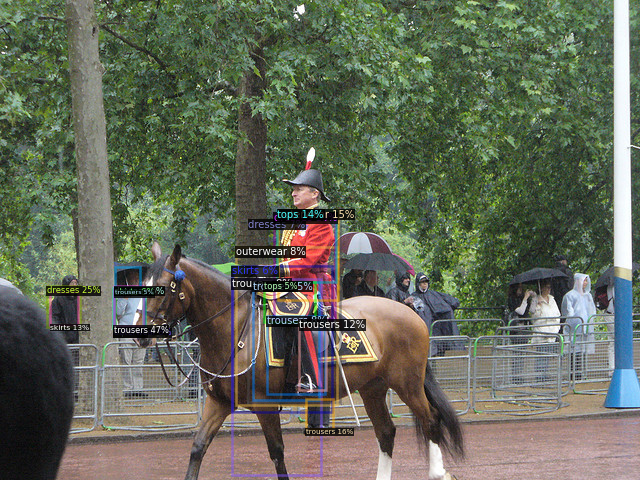

In [11]:
from detectron2.structures import Boxes, Instances
import torch

box_list = []
scores_list = []
class_list = []

for cropped,o in cropped_imgs:
    outputs = boxer(cropped)
    boxes = outputs['instances'].pred_boxes.tensor.cpu()+np.array([o[0],o[1],o[0],o[1]])
    scores = outputs['instances'].scores.cpu()
    classes = outputs['instances'].pred_classes.cpu()

    box_list.append(boxes)
    scores_list.append(scores)
    class_list.append(classes)

im_instance = Instances(im.shape[:2],pred_boxes=torch.cat(box_list),scores=torch.cat(scores_list),pred_classes=torch.cat(class_list))

v = Visualizer(im, MetadataCatalog.get("til_val"))
v = v.draw_instance_predictions(im_instance)
im_out = Image.fromarray(v.get_image()[:,:,::-1]) #channels are reversed
display(im_out)

In [9]:
class_list

[tensor([1, 2, 0, 1, 1, 1, 0, 3, 1, 3, 1])]

In [48]:
all(isinstance(i, Instances) for i in inst_list)

True

## Approaches
2. Upscaling: https://github.com/yu45020/Waifu2x ?????
4. map bbox back to original (how to increase cropping precision? upscale original image before cropping?)



### Good reason to use R101-FPN for everything:
1. It trains fast
2. It uses decent vram
3. It has near SOTA performance anyways
4. AND IT PREDICTS FAST ANYWAYS
5. why is this model so OP